# Multiple objective land allocation (MOLA)

This notebook present an example of a MOLA analysis using python. We set up the problem as a linear programming optimization problem and solve it with scipy.

In [ ]:
############### SESYNC Research Support: Urban green planning ########## 
## Testing optimization.
## 
##
## DATE CREATED: 11/15/2018
## DATE MODIFIED: 11/19/2018
## AUTHORS: Benoit Parmentier  
## Version: 1
## PROJECT: Urban green infrastructure planning
## ISSUE: 
## TO DO:
##
## COMMIT: fixed gdal.Warp bug, reprojection to MD SRS
##

###################################################
#

###### Library used

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import scipy
from math import cos

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
in_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/Data"
#in_dir <- "/nfs/tjovanovic-data/Data/Baltimore/Hydrology/GAstart"
#ARGS 2
out_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/outputs"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 7
out_suffix = "mola_example_11292018" #output suffix for the files and ouptut folder
#ARGS 8
num_cores = 2 # number of cores
file_format = ".tif"

#dem_baltimore_filename = "DEM_BaltArea_1m.tif"
#lc_baltimore_filename = "landCover_area1m.tif"
#reg_outline_filename = "watersheds8digit.shp"

################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir = "output_data_"+out_suffix
    out_dir = os.path.join(in_dir,out_dir)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

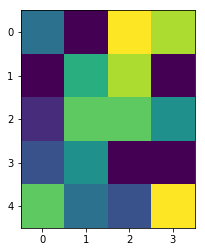

In [60]:
#######################################
### PART 1: Read in DATA #######

# Let's create a factor (attribute) in the multiobjective land allocation:

r_d = np.arange(25).reshape((5, 5))         # create a 1-d range and reshape
plt.imshow (r_d)

f2 = [3,0,8,7,
     0,5,7,0,
     1,6,6,4,
    2,4,0,0,
    6,3,2,8]
f2 = np.asarray(x)

r_d = x.reshape((5,4))         # distance to road
plt.imshow (r_d)



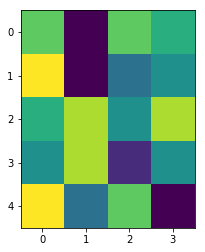

In [63]:
### Now generate second factor: Map slope

f2 = [6,0,6,5,
     8,0,3,4,
     5,7,4,7,
     4,7,1,4,
     8,3,6,0]
f2 = np.asarray(f2)

r_s = f2.reshape((5,4))         # slope map
plt.imshow (r_s)


#### Problem set up

Assume that you are land planner and you are tasked with selecting areas for the development of as ski resort whil setting aside land for Habitat protection. The steps are as follow:

1. Create factor maps (variables/criteria) relevant for your land use type objective.
2. Select, obtain or generate weights to combine your factor (e.g. AHP, SMART etc.)
3. Generate a suitability map for your land objective that combines all factors



[[15  0 30 26]
 [ 8 15 24  4]
 [ 8 25 22 19]
 [10 19  1  4]
 [26 12 12 24]]


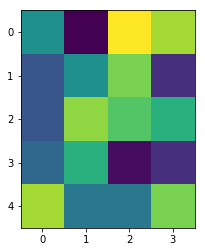

In [90]:
# Generate Habitat suitability 

r_suitability_habitat = 3*r_d + 1 * r_s 
print(r_suitability_habitat)
plt.imshow (r_suitability_habitat)
# note cell [1,1] is 15= 3*3 + 1*6

[[15  0 20 17]
 [16  5 13  8]
 [11 20 14 18]
 [10 18  2  8]
 [22  9 14  8]]


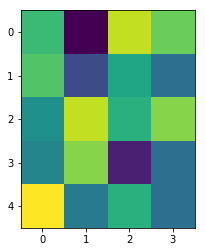

In [86]:
# Generate Ski resort suitability 

r_suitability_ski = 1*r_d +2*r_s 
#r_suitability_ski = np.add(1*r_d,2*r_s)

print(r_suitability_ski)
plt.imshow(r_suitability_ski)
# note cell [1,1] is 17= 1*5 + 2*6

[[17  8 12 11]
 [24  3  7 16]
 [17 16 10 18]
 [14 18 10 16]
 [18 11 18  0]]


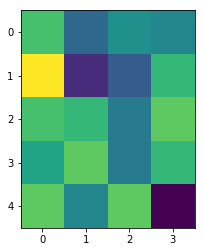

In [89]:
# Generate Ski resort suitability 

f1_ski = [5,8,0,1,
          8,3,1,8,
          7,2,2,4,
          6,4,8,8,
          2,5,6,0]

f2_ski = [6,0,6,5,
          8,0,3,4,
          5,7,4,7,
          4,7,1,4,
          8,3,6,0]

f1_ski = np.asarray(f1_ski)
f2_ski = np.asarray(f2_ski)

r_ski_s = f2_ski.reshape((5,4))         # slope map
plt.imshow (r_ski_s)
r_ski_d = f1_ski.reshape((5,4))         # distance map
plt.imshow (r_ski_d)

r_suitability_ski = 1*r_ski_d +2*r_ski_s 
#r_suitability_ski = np.add(1*r_d,2*r_s)

print(r_suitability_ski)
plt.imshow(r_suitability_ski)
# note cell [1,1] is 17= 1*5 + 2*6

In [93]:
# Set up linear problem for the land allocation

# Maximize 

import cvxpy
import numpy as np

# The data for the Knapsack problem
# P is total weight capacity of sack
# weights and utilities are also specified
P = 165
weights = np.array([23, 31, 29, 44, 53, 38, 63, 85, 89, 82])
utilities = np.array([92, 57, 49, 68, 60, 43, 67, 84, 87, 72])

# The variable we are solving for
selection = cvxpy.Bool(len(weights))

# The sum of the weights should be less than or equal to P
weight_constraint = weights * selection <= P

# Our total utility is the sum of the item utilities
total_utility = utilities * selection

# We tell cvxpy that we want to maximize total utility 
# subject to weight_constraint. All constraints in 
# cvxpy must be passed as a list
knapsack_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), [weight_constraint])

# Solving the problem
knapsack_problem.solve(solver=cvxpy.GLPK_MI)

AttributeError: module 'cvxpy' has no attribute 'Bool'

(-20, 20)

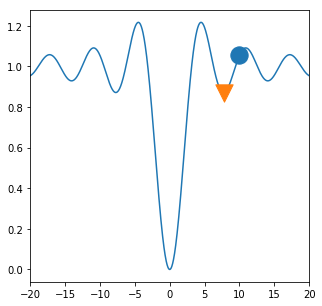

(-20, 20)

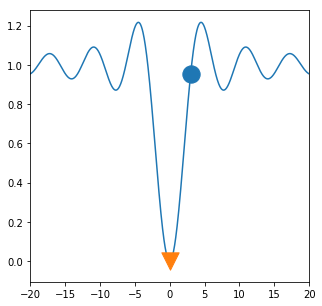

In [41]:
# We use 1000 iterations.
xmin = opt.basinhopping(f, x0, 1000).x
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y)
ax.scatter(x0, f(x0), marker='o', s=300)
ax.scatter(xmin, f(xmin), marker='v', s=300,
           zorder=20)
ax.set_xlim(-20, 20)



In [43]:
#now let's try two D
def g(X):
    # X is a 2*N matrix, each column contains
    # x and y coordinates.
    x, y = X
    return (np.sin(3*np.pi*x)**2 +
            (x-1)**2 * (1 + np.sin(3*np.pi*y)**2) +
            (y-1)**2 * (1 + np.sin(2*np.pi*y)**2))

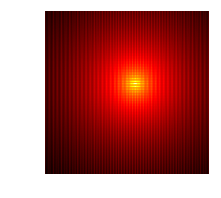

In [44]:
n = 500
k = 10
X, Y = np.mgrid[-k:k:n * 1j,
                -k:k:n * 1j]
Z = g(np.vstack((X.ravel(), Y.ravel()))).reshape(n, n)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# We use a logarithmic scale for the color here.
ax.imshow(np.log(Z), cmap=plt.cm.hot_r,
          extent=(-k, k, -k, k), origin=0)
ax.set_axis_off()

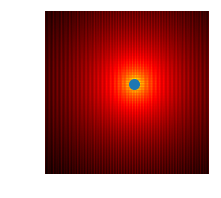

In [45]:
# We use the Powell method.
x0, y0 = opt.minimize(g, (8, 3),
                      method='Powell').x
x0, y0
(1.000, 1.000)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(np.log(Z), cmap=plt.cm.hot_r,
          extent=(-k, k, -k, k), origin=0)
ax.scatter(x0, y0, s=100)
ax.set_axis_off()

#https://ipython-books.github.io/92-minimizing-a-mathematical-function/
    